In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from pathlib import Path
import numpy as np
import random
import os
from datetime import datetime
import joblib


In [11]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:


def prepare_data(file_list):
    df = pd.concat((pd.read_csv(f, sep=";") for f in file_list))
    features = df.drop('ThrottleA', axis=1)
    target = df['ThrottleA']

    # Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Reshaping the input for LSTM
    scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))
    
    return scaled_features, target, scaler

csv_path = Path("./TruncatedData")

my_regex = ".+CP(\d).+"
location_regex = ".+CP(\d).+(NYC).+"
wanted_CP_number = 1

file_list = []
for file_path in csv_path.rglob('*.csv'):
    if re.match(my_regex, file_path.name):
        if re.match(my_regex, file_path.name).group(1) == str(wanted_CP_number):
            if re.match(location_regex, file_path.name):
                file_list.append(file_path)
                print(file_path)

scaled_features, target, scaler = prepare_data(file_list)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(scaled_features.shape[1], scaled_features.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mse')

# Early stopping  --- This seems very unstable at the current point... Need to play with it more
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(scaled_features, target, epochs=50, validation_split=0.2, callbacks=[early_stopping])




TruncatedData\NYC10\csv\CSVScenario-CP1_Session-NYC10_2022-09-14-11-57-16.csv
TruncatedData\NYC11\csv\CSVScenario-CP1_Session-NYC11_2022-09-14-16-26-15.csv
TruncatedData\NYC12\csv\CSVScenario-CP1_Session-NYC12_2022-09-15-09-44-53.csv
TruncatedData\NYC13\csv\CSVScenario-CP1_Session-NYC13_2022-09-15-11-13-58.csv
TruncatedData\NYC14\csv\CSVScenario-CP1_Session-NYC14B_2022-09-15-15-29-12.csv
TruncatedData\NYC15\csv\CSVScenario-CP1_Session-NYC15_2022-09-16-09-57-43.csv
TruncatedData\NYC16\csv\CSVScenario-CP1_Session-NYC16_2022-09-16-15-37-55.csv
TruncatedData\NYC17\csv\CSVScenario-CP1_Session-NYC17_2022-09-16-17-28-03.csv
TruncatedData\NYC18\csv\CSVScenario-CP1_Session-NYC18_2022-09-19-11-41-57.csv
TruncatedData\NYC19\csv\CSVScenario-CP1_Session-NYC19_2022-09-19-13-40-44.csv
TruncatedData\NYC2\csv\CSVScenario-CP1_Session-NYC2_2022-08-09-14-52-30.csv
TruncatedData\NYC20\csv\CSVScenario-CP1_Session-NYC20_2022-09-19-15-12-43.csv
TruncatedData\NYC21\csv\CSVScenario-CP1_Session-NYC21_2022-09-19-

In [13]:
# save the model

models_path = Path('./Models')

now = datetime.now()

now_string = now.strftime("%Y-%m-%d_%H-%M-%S")

model_path = models_path / f'model_{now_string}'

model.save(model_path)

# Save the scaler
scaler_path = model_path / f'scaler.pkl'
joblib.dump(scaler, scaler_path)

INFO:tensorflow:Assets written to: Models\model_2023-07-25_14-24-44\assets


['Models\\model_2023-07-25_14-24-44\\scaler.pkl']

18/18 [==============================] - 0s 997us/step


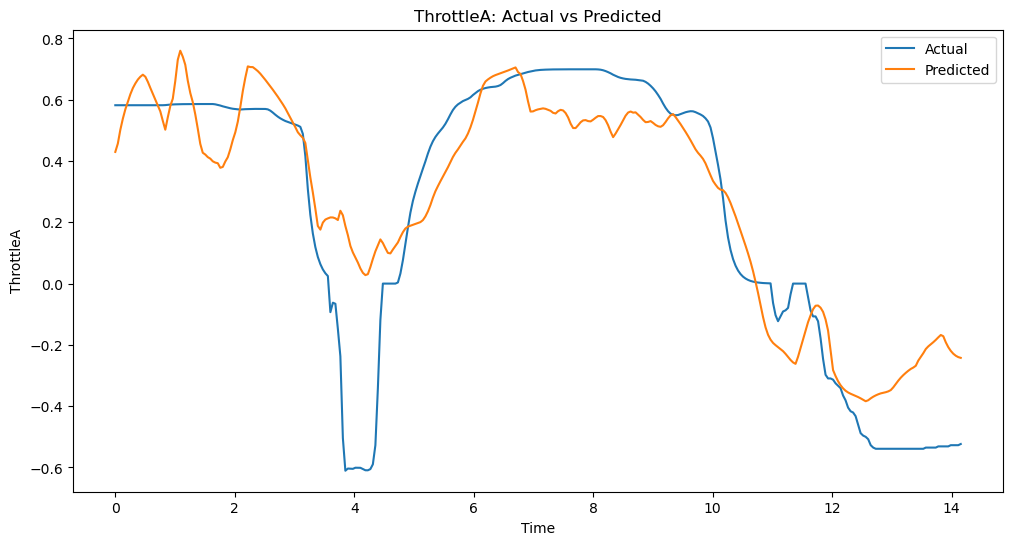

18/18 [==============================] - 0s 1ms/step


In [25]:
# Load the model

model_path = Path('./Models/model_2023-07-25_11-23-19')
loaded_model = load_model(model_path)
scaler_path = model_path / 'scaler.pkl'

loaded_scaler = joblib.load(scaler_path)


# Load new data
new_data = pd.read_csv(r".\VerificationData\CSVScenario-CP1_Session-NYC28_2022-10-28-10-02-58.csv", sep=";")

new_features = new_data.drop('ThrottleA', axis=1)
scaled_new_features = loaded_scaler.transform(new_features)
scaled_new_features = np.reshape(scaled_new_features, (scaled_new_features.shape[0], 1, scaled_new_features.shape[1]))

new_target = new_data['ThrottleA']

# Predict
predictions = loaded_model.predict(scaled_new_features)

# Plotting the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(new_data['ScenarioTime'], new_target.values, label='Actual')
plt.plot(new_data['ScenarioTime'], predictions, label='Predicted')
plt.title('ThrottleA: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('ThrottleA')
plt.legend()
plt.show()



# Predict
predictions = loaded_model.predict(scaled_new_features)

#for prediction in predictions:
    #print(prediction)



In [ ]:
df = pd.read_csv(r".\VerificationData\CSVScenario-CP1_Session-ISR02_2022-05-31-15-21-40.csv", sep=";")

new_features = new_data.drop('ThrottleA', axis=1)
new_target = new_data['ThrottleA']

model = load_model("your_model_path.h5")  # Replace with your model path
scaler = StandardScaler()  # Replace with your scaler

predictions = []

for i in range(len(new_features)):
    temp_data = new_features.iloc[0:i+1, :]
    
    scaled_temp_data = scaler.transform(temp_data)
    
    scaled_temp_data = np.reshape(scaled_temp_data, (1, scaled_temp_data.shape[0], scaled_temp_data.shape[1]))
    
    prediction = model.predict(scaled_temp_data)
    
    predictions.append(prediction[0,0])

plt.figure(figsize=(12,6))
plt.plot(new_data['ScenarioTime'], new_target.values, label='Actual')
plt.plot(new_data['ScenarioTime'], predictions, label='Predicted')
plt.title('ThrottleA: Actual vs Predicted')
plt.xlabel('Observations')
plt.ylabel('ThrottleA')
plt.legend()
plt.show()
